### A brief about Challenge

* Problem Statement
  > Paper ref. - https://sci-hub.se/10.1145/2818346.2829994

  > To assign a single emotion label to the video clip from the eight universal emotions (Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised and Neutral) on the given multimodal dataset. Use the first 20 actors for the training and rest(04) for testing.

* Approach

  > ConvNet (Spatial features) + LSTM (temporal features)
  
* Metrics
  > Confusion Matrix + Precision + Recall + F1 score

* References - 
1. The Ryerson Audio-Visual Database of Emotional Speech and Song(RAVDESS) Dataset - https://zenodo.org/record/1188976
2. https://discuss.pytorch.org/t/how-upload-sequence-of-image-on-video-classification/24865 
3. https://discuss.pytorch.org/t/solved-concatenate-time-distributed-cnn-with-lstm/15435
4. https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/#heading4

#### Necessary Imports 

In [ ]:
!pip install -q torchinfo
!apt-get install tree

import os
import io
import zipfile
from collections import OrderedDict
import shutil

import cv2 as cv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchinfo import summary

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import datasets, models, transforms

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (81.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


#### Setup Dataset

> The format of the dataset provided to us is in the form of a zip file, we unzip and restructure into a train and test dir. After initial restructuring the dataset is stored:

* from: /content/audio_video/\
├── Actor_01 \
├── Actor_02 \
├── Actor_03 \
├── Actor_04 \
    ...

* to:/content/audio_video/train/\
├── angry\
│   ├── Actor_01\
│   ├── Actor_02\
    ...\
├── calm\
│   ├── Actor_01\
│   ├── Actor_02\
    ... 

Similarly for test dir ...

After initial observation, we realize that the task is 

In [ ]:
def download_dataset(filename='/content/drive/MyDrive/HMI/audio-video.zip',
                     dirname='/content/audio_video/',
                     preprocessed=True):
  ''' 
  Mount Google Drive and recursively unzip the dataset 
  to their respective dirs inside a dir passed as an arg
  '''
  
  # mount google drive
  if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
  
  if preprocessed:
    !unzip -q /content/drive/MyDrive/HMI/audio_video.zip
    shutil.move('/content/content/audio_video', '/content/audio_video')
    shutil.rmtree('/content/content')
    train_df = pd.read_csv('/content/drive/MyDrive/HMI/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/HMI/test.csv')
  else:
    with zipfile.ZipFile(filename) as zip_files:
      for zip_file in tqdm(zip_files.namelist()[1:]):
        data = io.BytesIO(zip_files.read(zip_file))
        _zip_file = zipfile.ZipFile(data)
        _zip_file.extractall(dirname)

download_dataset(preprocessed=False)


  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
# dir structure
!tree -d /content/audio_video/

In [ ]:
# defining train and test dir paths
TRAIN_DIR = '/content/audio_video/train'
TEST_DIR = '/content/audio_video/test'

idx2class = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
class2idx = {cls:idx for idx, cls in enumerate(idx2class)}

In [ ]:
def get_emotion(file):
  ''' 
  returns the emotion based upon the filename
  '''
  if file.startswith('02-01-01'):
    return f'neutral'
  elif file.startswith('02-01-02'):
    return f'calm'
  elif file.startswith('02-01-03'):
    return f'happy'
  elif file.startswith('02-01-04'):
    return f'sad'
  elif file.startswith('02-01-05'):
    return f'angry'
  elif file.startswith('02-01-06'):
    return f'fearful'
  elif file.startswith('02-01-07'):
    return f'disgust'
  elif file.startswith('02-01-08'):
    return f'surprised'

In [ ]:
def structure_dir(src='/content/audio_video', n_samples=20):
  '''
    returns a reorganized directory structure by splitting the dataset into TRAIN/TEST and includes only videos:
    TRAIN (0-20 actors)- /audio_video/train
    TEST (21-24) - /audio_video/test
  '''
  dirs = os.listdir(src)
  dirs.sort()
  train_dirs = dirs[:n_samples]
  test_dirs = dirs[n_samples:]

  if not os.path.exists(TRAIN_DIR):
    for cls in idx2class:
      for dir in train_dirs:
        os.makedirs(f'{TRAIN_DIR}/{cls}/{dir}', exist_ok=True)

  if not os.path.exists(TEST_DIR):
    for cls in idx2class:
      for dir in test_dirs:
        os.makedirs(f'{TEST_DIR}/{cls}/{dir}', exist_ok=True)

  for dir in tqdm(train_dirs):
    for file in os.listdir(f'{src}/{dir}'):
      dst = f'{TRAIN_DIR}/{get_emotion(file)}/{dir}'
      if 'None' not in dst and os.path.isfile(f'{src}/{dir}/{file}'):
        shutil.move(f'{src}/{dir}/{file}', f'{dst}/{file}')
    shutil.rmtree(f'{src}/{dir}')
    
  for dir in tqdm(test_dirs):
    for file in os.listdir(f'{src}/{dir}'):
      dst = f'{TEST_DIR}/{get_emotion(file)}/{dir}'
      if 'None' not in dst and os.path.isfile(f'{src}/{dir}/{file}'):
        shutil.move(f'{src}/{dir}/{file}', f'{dst}/{file}')
    shutil.rmtree(f'{src}/{dir}')

structure_dir()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
!tree -d /content/audio_video/train/

#### Feature Extraction

Videos are just sequences of images (frames). Usually there are multiple frames in a second. Moreover, most of these frames don't have information that is significantly different. Also, the frames which that are redundant are usually the successive ones. Hence, we extract `n_frames` from each video and store them in their respective dir. Furthermore, it is a trick to reduce the complexity.


In [ ]:
def get_frames(src, n_frames=16):
  '''
  returns a list of evenly spaced n_frames extracted from each video 
  '''
  frames_list = []
  video = cv.VideoCapture(src)

  # total frames
  vframes = int(video.get(cv.CAP_PROP_FRAME_COUNT)) 

  # frames to be selected
  frames_idx = np.linspace(0, vframes-1, n_frames+1, dtype=np.int16)
  
  for f in range(vframes):
    (grabbed, frame) = video.read()

    if not grabbed:
      break

    if f in frames_idx:
      frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
      frames_list.append(frame)

  video.release()
  return frames_list
 

def store_frames(frames_list, dst):
  '''
  stores a set of imgs. from the extracted n_frames of each video and
  returns a list of frames with all the details
  '''
  video_name = os.path.basename(dst)
  # print('video_name:',video_name)         # 02-01-05-01-01-02-09
  
  dst = os.path.dirname(dst)
  # print('dst:',dst)                       # /content/audio_video/train/angry/Actor_12

  emotion = get_emotion(video_name)

  actor = os.path.basename(dst)

  frames_dict = []

  for ii, frame in enumerate(frames_list):
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    
    path2img = f'{dst}/{video_name}_frame_{str(ii)}.jpg'
    # print('path2img:',path2img)           # /content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_0.jpg

    dict4df = {'path2img':path2img, 'actor':actor, 'emotion':emotion, 'target':class2idx[emotion]}
    
    frames_dict.append(dict4df)
    cv.imwrite(path2img, frame)
  
  return frames_dict


In [ ]:
def create_dataset(avtrain_df, avtest_df, n_frames=16):
  '''
  extract n_frames(imgs.) from each video and store them as jpg imgs.
  '''
  emotions = os.listdir(TRAIN_DIR)

  for emotion in tqdm(emotions):
    for actor in tqdm(os.scandir(f'{TRAIN_DIR}/{emotion}')):
      for file in os.listdir(f'{TRAIN_DIR}/{emotion}/{actor.name}'):
        filename = f'{TRAIN_DIR}/{emotion}/{actor.name}/{file}'
        frames = get_frames(filename)
        train_frames = store_frames(frames, os.path.splitext(filename)[0])
        avtrain_df = avtrain_df.append(train_frames)
        os.remove(filename)

  emotions = os.listdir(TEST_DIR)

  for emotion in tqdm(emotions):
    for actor in tqdm(os.scandir(f'{TEST_DIR}/{emotion}')):
      for file in os.listdir(f'{TEST_DIR}/{emotion}/{actor.name}'):
        filename = f'{TEST_DIR}/{emotion}/{actor.name}/{file}'
        frames = get_frames(filename)
        test_frames = store_frames(frames, os.path.splitext(filename)[0])
        avtest_df = avtest_df.append(test_frames)
        os.remove(filename)

  return avtrain_df, avtest_df

train_df = pd.DataFrame(columns=['path2img', 'target', 'emotion'])
test_df = pd.DataFrame(columns=['path2img', 'target', 'emotion'])

train_df, test_df = create_dataset(avtrain_df=train_df, avtest_df=test_df)


#### Minimal EDA 

In [ ]:
# sanity check
print(train_df.shape)

print(test_df.shape)

# save as csv file
train_df.to_csv('/content/drive/MyDrive/HMI_backup/train.csv')

test_df.to_csv('/content/drive/MyDrive/HMI_backup/test.csv')

(19920, 4)
(4080, 4)


emotion
angry        2656
calm         2656
disgust      2656
fearful      2656
happy        2656
neutral      1328
sad          2656
surprised    2656
Name: target, dtype: int64


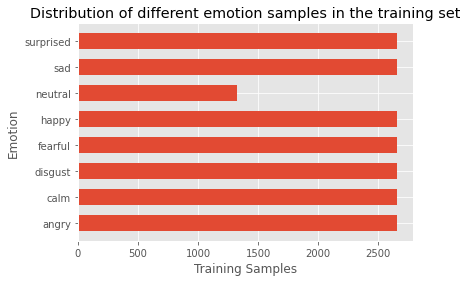

In [ ]:
def plot_distribution(df=train_df):
  ''' plots a bar chart indication the distribution of emotions'''

  plt.style.use('ggplot')

  fig, ax = plt.subplots()

  samples = df.groupby(['emotion'])['target'].agg('count')
  print(samples)

  data = [sample for sample in samples]
  labels = sorted(df['emotion'].unique())
  ax.set_title(f"Distribution of different emotion samples in the training set")
  
  ax.barh(labels, data, height=0.6)
  ax.set_xlabel('Training Samples')
  ax.set_ylabel('Emotion')
  ax.set_yticklabels(labels)
      
  plt.show()

plot_distribution()

The above bar plot shows that the dataset is quite balanced. This helps us to estabilish that even Classification as an evaluation metric would be suitable. Also, we are relieved of handling the data imbalance. 

In [ ]:
def train_val_split(df=train_df, split=0.2):
  ''' splits the training set into 80:20 (default) and returns a val_df '''

  actors = df['actor'].unique().tolist()
  actors.sort()

  val_size = int(split*len(actors))
  # print(val_size)

  val_actors = actors[-val_size:]
  print(val_actors)

  val_df = df.loc[df['actor'].isin(val_actors)]

  return val_df

val_df = train_val_split()
print(val_df.shape)

['Actor_17', 'Actor_18', 'Actor_19', 'Actor_20']
(3960, 4)


In [ ]:
pd.set_option('display.max_colwidth', None)

train_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_0.jpg,4,angry,Actor_12
1,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_1.jpg,4,angry,Actor_12
2,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_2.jpg,4,angry,Actor_12
3,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_3.jpg,4,angry,Actor_12
4,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_4.jpg,4,angry,Actor_12


In [ ]:
val_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_0.jpg,4,angry,Actor_18
1,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_1.jpg,4,angry,Actor_18
2,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_2.jpg,4,angry,Actor_18
3,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_3.jpg,4,angry,Actor_18
4,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_4.jpg,4,angry,Actor_18


In [ ]:
test_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_0.jpg,4,angry,Actor_24
1,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_1.jpg,4,angry,Actor_24
2,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_2.jpg,4,angry,Actor_24
3,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_3.jpg,4,angry,Actor_24
4,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_4.jpg,4,angry,Actor_24


In [ ]:
# transforms for the dataset
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224,224)),                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])                         
                                   ])

After observing the dataset, we could conclude that not only different emotions need to be classified but also the actors shouldn't be mixed up. Hence, we need to calculate valid frames per emotion per actor. The Sampler ensures that only valid frames are selected from the complete dataset. 

In [ ]:
def get_frame_idx(df=train_df):
  '''
  returns a list of end frame indices for each emotion n actor   
  '''
  frame_idx = [0]

  idx = df.groupby(['emotion', 'actor'])['path2img'].count().values
  idx = idx.tolist()

  frame_idx.extend(idx)

  return torch.cumsum(torch.tensor(frame_idx), dim=0)


class AVSampler(Sampler):
  '''Custom Sampling Class for selection of valid frames'''
  def __init__(self, frame_idx, n_frames):
    frames = []
    for i in range(len(frame_idx)-1):
      start = frame_idx[i] 
      end = frame_idx[i+1] - n_frames
      frames.append(torch.arange(start, end))
    frames = torch.cat(frames)
    self.frames = frames

  def __iter__(self):
    frames = self.frames[torch.randperm(len(self.frames))]
    return iter(frames.tolist())
    
  def __len__(self):
    return len(self.frames)


class AVDataset(Dataset):
  ''' Custom Dataset Class '''
  def __init__(self, length, df=train_df, transform=train_transforms, n_frames=16):
    self.length = length
    self.df = df
    self.transform = transform
    self.n_frames = n_frames

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    ''' returns a data sample(img.) after applying transforms & the associated target(y_label) for a key(idx/index)'''
    frames_start = idx
    frames_end = idx + self.n_frames
    idxs = list(range(frames_start, frames_end))

    imgs = []
    for i in idxs:
      img_path = self.df.iloc[i]['path2img'] 
      img = cv.imread(img_path)
      img = self.transform(img)
      imgs.append(img)

    imgs = torch.stack(imgs)
    y_label = torch.tensor(self.df.iloc[frames_start]['target'], dtype=torch.long)
    
    return (imgs, y_label)


In [ ]:
# HYPERPARAMS
BATCH_SIZE = 32
EPOCHS = 1
LR = 1e-3
PATIENCE = 3
FACTOR = 0.1

# valid frame indices
train_frame_idx = get_frame_idx(df=train_df)
val_frame_idx = get_frame_idx(df=val_df)
test_frame_idx = get_frame_idx(df=test_df)

train_sampler = AVSampler(train_frame_idx, n_frames=16)
val_sampler = AVSampler(val_frame_idx, n_frames=16)
test_sampler = AVSampler(test_frame_idx, n_frames=16)

train_data = AVDataset(length=len(train_sampler), df=train_df, transform=train_transforms)
val_data = AVDataset(length=len(val_sampler), df=val_df, transform=test_transforms)
test_data = AVDataset(length=len(test_sampler), df=test_df, transform=test_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, sampler=test_sampler, shuffle=False)

In [ ]:
# sanity check

# obtain a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 16, 3, 224, 224])
torch.Size([32])


#### Approach, Model Architecture and Traning

Different approaches are available to solve the problem ranging from hacky schemes (Single frame CNN) to 3D CNNs. Since the video clips were devoid of background features, we need to capitalize on the sequence. ConvNet combined with an LSTM would be a good choice as the ConvNet would be able to extract spatial features and the LSTM would extract the temporal features. 

In [ ]:
class ResNet18_LSTM(nn.Module):
  '''
  returns a pretrained ConvNet (resnet18) + LSTM model
  '''
  def __init__(self, n_class, pretrained=True, freeze=True):
    super(ResNet18_LSTM, self).__init__()
    # pretrained resnet18
    self.pretrainedmodel = models.resnet18(pretrained=pretrained)

    if freeze:
      for param in self.pretrainedmodel.parameters():
        param.requires_grad = False

    # attach a linear classifier
    self.pretrainedmodel.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(self.pretrainedmodel.fc.in_features,256)),
                          ]))
    
    # pass the features into an LSTM
    self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
  
    # linear classifier 
    # self.fc2 = nn.Linear(in_features=128, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=n_class)


  def yolomod(self, model, brief=True):
    ''' yolomod: you only look once at the model description'''
    if brief:
      print(summary(model))
    else:
      print(model)


  def forward(self, frames):
    bs, ts, c, h, w = frames.shape

    final_state = None
    for t in range(ts):
      with torch.no_grad():
        x = self.pretrainedmodel(frames[:, t, :, :, :])
        
        # print('features extracted:', x.shape)                                       # OUTPUT: [32, 256]
        # print('Input 2 LSTM :', x.unsqueeze(0).shape)                               # OUTPUT: [1, 32, 256]
        # print('Input 2 LSTM :', x.unsqueeze(1).shape)                               # OUTPUT: [32, 1, 256]

        _output, final_state = self.lstm(x.unsqueeze(1), final_state)
        # print('_output:', _output.shape)                                            # OUTPUT: [32, 1, 128]

    # print('_output[-1, :, :]: ', _output[:, -1].shape)                              # OUTPUT: [32, 128]
    # print('self.fc2(output[-1, :, :]): ', self.fc2(_output[-1, :, :]).shape)

    # output = F.relu(self.fc2(_output[:, -1]))

    # print('F.relu(self.fc2(_output[-1, :, :])): ', output.shape)
    
    output = self.fc2(_output[:, -1])
    # print('output:', output.shape)                      # OUTPUT: [32, 8]
    
    return output    

model = ResNet18_LSTM(n_class=8)
# model.yolomod(model, brief=False)

# initialize device as cuda if on GPU
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print(f'on {device}!')
  model.to(device)
else:
  device = torch.device("cpu")
  print(f'on {device}!')


on cuda:0!


In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# specify scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=PATIENCE, factor=FACTOR, verbose=True)

In [ ]:
# best_val_f1 = -np.Inf
val_loss_min = np.Inf

losses = {
    'train_losses': [],
    'val_losses': []
}

for epoch in range(1, EPOCHS+1):
  
  train_loss, train_accuracy = 0.0, 0.0

  model.train()

  for images, labels in train_loader:

    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    scores = model(images)

    loss = criterion(scores, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()

    train_predictions = F.softmax(scores, dim=1)

    _, train_top_class = train_predictions.topk(1, dim=1)
   
    train_equals = train_top_class == labels.view(*train_top_class.shape)
  
    train_accuracy = torch.mean(train_equals.type(torch.FloatTensor))

  else:

    with torch.no_grad():
      model.eval()

      val_loss, val_accuracy = 0.0, 0.0

      for images, labels in val_loader:
        
        images, labels = images.to(device), labels.to(device)

        scores = model(images)

        loss = criterion(scores, labels)
        
        val_loss += loss.item()

        val_predictions = F.softmax(scores, dim=1) 

        _, val_top_class = val_predictions.topk(1, dim=1)
      
        # calc. correct classes (Compare top_k and labels)
        val_equals = val_top_class == labels.view(*val_top_class.shape)
      
        # calc. accuracy
        val_accuracy = torch.mean(val_equals.type(torch.FloatTensor))

    train_loss = train_loss/len(train_loader)
    losses['train_losses'].append(train_loss)

    val_loss = val_loss/len(val_loader) 
    losses['val_losses'].append(val_loss)

    print(f'----- Epoch: {epoch}/{EPOCHS} ----- ')
    print(f'Train Accuracy: {train_accuracy:.6f} || Validation Accuracy: {val_accuracy:.6f}')
    print(f'Train Loss: {train_loss:.6f} || Val Loss: {val_loss:.6f}')

    scheduler.step(val_loss)

    # save model if validation loss has decreased
    if val_loss <= val_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
      torch.save(model.state_dict(), '/content/mvc.pth')
      val_loss_min = valid_loss


KeyboardInterrupt: ignored